In [1]:
import cv2
import os
import os.path
import sys
import torch
import matplotlib.pyplot as plt
import numpy as np

from network import Model

In [2]:
width = 25
height = 25
channel = 1

In [3]:
net = Model()

In [4]:
def show_image(tensor_list):
    
    # 将选定的帧转换为numpy数组
    frame_np = tensor_list.squeeze().numpy()  # 直接使用squeeze()和numpy()，省略permute()
    
    # 将数据类型从float转换回uint8（如果之前进行了归一化）
    frame_np = (frame_np * 255).astype(np.uint8)
    
    # 使用matplotlib展示这一帧
    import matplotlib.pyplot as plt
    
    plt.imshow(frame_np, cmap='gray')  # 对于灰度图，确保使用正确的颜色映射
    plt.title(f'Frame {0}')
    plt.axis('off')  # 不显示坐标轴
    plt.show()


In [5]:
video_path = '../InputVideo/Train_Video'
label_path = '../InputVideo/Train_Label'

video_files = [f for f in sorted(os.listdir(video_path)) if f.endswith('.avi')]
label_files = [f for f in sorted(os.listdir(label_path)) if f.endswith('.txt')]
print(video_files)
print(label_files)

test_video_file = []
test_label_file = []
train_video_file = []
train_label_file = []

for index in range(len(video_files)):
    if index % 4 == 0:
        test_video_file.append(video_files[index])
        test_label_file.append(label_files[index])
    else:
        train_video_file.append(video_files[index])
        train_label_file.append(label_files[index])

print(test_video_file)
print(test_label_file)
print(train_video_file)
print(train_label_file)

['STMD_0.avi', 'STMD_1.avi', 'STMD_2.avi', 'STMD_3.avi', 'STMD_4.avi', 'STMD_5.avi', 'STMD_6.avi', 'STMD_7.avi', 'STMD_8.avi', 'STMD_9.avi']
['STMD_0.txt', 'STMD_1.txt', 'STMD_2.txt', 'STMD_3.txt', 'STMD_4.txt', 'STMD_5.txt', 'STMD_6.txt', 'STMD_7.txt', 'STMD_8.txt', 'STMD_9.txt']
['STMD_0.avi', 'STMD_4.avi', 'STMD_8.avi']
['STMD_0.txt', 'STMD_4.txt', 'STMD_8.txt']
['STMD_1.avi', 'STMD_2.avi', 'STMD_3.avi', 'STMD_5.avi', 'STMD_6.avi', 'STMD_7.avi', 'STMD_9.avi']
['STMD_1.txt', 'STMD_2.txt', 'STMD_3.txt', 'STMD_5.txt', 'STMD_6.txt', 'STMD_7.txt', 'STMD_9.txt']


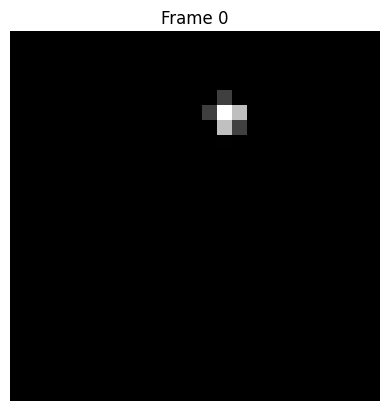

In [6]:
## Load All Videos
InputSize = 0
InputVideoRatio = None
videos = {}
for filename in video_files:
    videoLoader = cv2.VideoCapture(video_path + "/" + filename)
    n = 0
    frame_tensors = []
    while True:
        ret, frame = videoLoader.read()
        if ret is False:
            break
        # 1. 将BGR图像转换为灰度图
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # 2. 将数据类型转换为float32，并缩放到0-1范围
        frame_gray = frame_gray.astype(np.float32) / 255.0
        # 3. 重新调整图像尺寸（如果需要保持原尺寸，这一步可以省略）
        frame_resized = cv2.resize(frame_gray, (width, height))
        # 4. 将numpy数组转换为torch Tensor，并确保其形状为[1, height, width]，这里不需要使用permute
        frame_tensor = torch.tensor(frame_resized).unsqueeze(0).unsqueeze(0)  # 在0位置增加两个维度，变为[1, 1, height, width]
        frame_tensors.append(frame_tensor)
    videoLoader.release()
    videos[filename] = frame_tensors


frames_tensor = torch.cat(videos[video_files[3]], dim=0)  # 结果维度为 [帧数, 通道数, 高度, 宽度]
selected_frame = frames_tensor[0]

# 将选定的帧转换为numpy数组
frame_np = selected_frame.squeeze().numpy()  # 直接使用squeeze()和numpy()，省略permute()

# 将数据类型从float转换回uint8（如果之前进行了归一化）
frame_np = (frame_np * 255).astype(np.uint8)

# 使用matplotlib展示这一帧
import matplotlib.pyplot as plt

plt.imshow(frame_np, cmap='gray')  # 对于灰度图，确保使用正确的颜色映射
plt.title(f'Frame {0}')
plt.axis('off')  # 不显示坐标轴
plt.show()

In [7]:
print(videos.keys())

dict_keys(['STMD_0.avi', 'STMD_1.avi', 'STMD_2.avi', 'STMD_3.avi', 'STMD_4.avi', 'STMD_5.avi', 'STMD_6.avi', 'STMD_7.avi', 'STMD_8.avi', 'STMD_9.avi'])


In [8]:
## Load Cooresponding Labels (Spike Time)
spike_times = {}
for labelName in label_files:
    spikes = [0] * len(frames_tensor)
    with open(label_path + "/" + labelName, 'r') as file:
        for line in file:
            try:
                spike_index = int(line.strip())
                spikes[spike_index] = 1
            except ValueError:
                print(f"Skipping invalid number: {line.strip()}")
    spike_tensor = torch.tensor([element / 2 for element in spikes])
    spike_times[labelName] = spike_tensor

print(spike_times[label_files[0]])

tensor([0.0000, 0.0000, 0.5000,  ..., 0.0000, 0.0000, 0.0000])


In [9]:
for name in video_files:
    print(videos[name][2].shape) ## 输出为[帧数，通道数，宽度，高度]

for name in label_files:
    print(spike_times[name].shape)

torch.Size([1, 1, 25, 25])
torch.Size([1, 1, 25, 25])
torch.Size([1, 1, 25, 25])
torch.Size([1, 1, 25, 25])
torch.Size([1, 1, 25, 25])
torch.Size([1, 1, 25, 25])
torch.Size([1, 1, 25, 25])
torch.Size([1, 1, 25, 25])
torch.Size([1, 1, 25, 25])
torch.Size([1, 1, 25, 25])
torch.Size([9000])
torch.Size([9000])
torch.Size([9000])
torch.Size([9000])
torch.Size([9000])
torch.Size([9000])
torch.Size([9000])
torch.Size([9000])
torch.Size([9000])
torch.Size([9000])


In [10]:
from torch.utils.data import Dataset, DataLoader
import torch

class VideoFrameDataset(Dataset):
    def __init__(self, data_dict, label_dict):
        """
        初始化数据集
        :param data_dict: 包含视频帧数据的字典，键为文件名，值为帧的张量列表
        :param label_dict: 包含帧标签的字典，键为文件名，值为对应帧的标签张量列表
        """
        self.data = []
        self.labels = []
        
        # 将视频帧和标签转换为一个长列表
        for video_name in data_dict.keys():
            # 使用与视频文件名相对应的标签文件名
            label_name = video_name.replace('.avi', '.txt')
            
            # 检查视频文件和标签文件是否匹配
            if label_name in label_dict:
                for frame_data, frame_label in zip(data_dict[video_name], label_dict[label_name]):
                    self.data.append(frame_data)
                    self.labels.append(frame_label)
            else:
                print(f"Warning: Missing labels for {video_name}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # 获取索引对应的数据和标签
        data_item = self.data[index]
        label_item = self.labels[index]
        return data_item, label_item

# 假设data_dict和label_dict已经定义并包含了数据和标签
# data_dict = {'STMD_0.avi': [frame1, frame2, ...], ...}
# label_dict = {'STMD_0.txt': [label1, label2, ...], ...}

In [11]:
train_video_set = {}
train_label_set = {}
test_label_set = {}
test_video_set = {}
batch_size = 8
for name in videos:
    if name in train_video_file:
        train_video_set[name] = videos[name]
    else:
        test_video_set[name] = videos[name]
    

for name in spike_times:
    if name in train_label_file:
        train_label_set[name] = spike_times[name]
    else:
        test_label_set[name] = spike_times[name]

train_Dataset = VideoFrameDataset(train_video_set, train_label_set)
test_Dataset = VideoFrameDataset(test_video_set, test_label_set)

train_loader = DataLoader(dataset=train_Dataset, batch_size=batch_size, shuffle=True)
test_loader =  DataLoader(dataset=test_Dataset, batch_size=batch_size)

Batch 1
Images shape: torch.Size([8, 1, 1, 25, 25])
Labels shape: torch.Size([8])
First image in batch: tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e

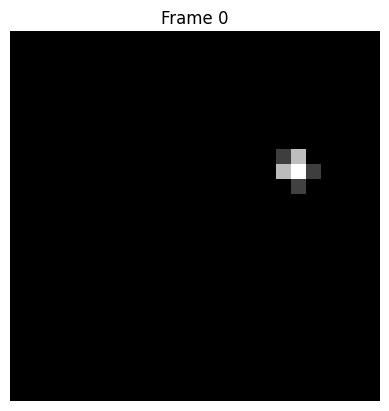

In [12]:
for i, (images, labels) in enumerate(train_loader):
    # images 和 labels 是这个批次的数据和标签
    # 注意：这里的 images 和 labels 的具体形状依赖于你的 Dataset 类是如何实现的
    
    print(f"Batch {i+1}")
    print(f"Images shape: {images.shape}")  # 打印图像张量的形状
    print(f"Labels shape: {labels.shape}")  # 打印标签张量的形状
    
    # 举例来说，你可以查看第一张图像和它的标签
    # 注意：图像数据可能需要进行处理（如归一化逆转换）才能正确显示
    first_frame = images[0]  # 获取批次中的第一张图像
    first_label = labels[0]  # 获取第一张图像对应的标签
    
    # 打印第一张图像和它的标签
    # 注意：这里只是示例代码，实际使用时可能需要根据你的数据进行适当调整
    print(f"First image in batch: {first_frame}")
    print(f"Label for first image: {first_label}")

    show_image(first_frame)
    break

In [13]:
from network import Model
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

net = Model()
criterion = nn.MSELoss()
learning_rate = 0.0001
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
        
EPOCHS = 20
for epoch in range(1, EPOCHS + 1):
    processBar = tqdm(train_loader, unit='step')
    net.train(True)
    for step, (trainImgs, labels) in enumerate(processBar):
        # 展平图像：从 [batch_size, 25, 25] 变为 [batch_size, 625]
        flattened_trainImgs = trainImgs.view(trainImgs.size(0), -1)

        optimizer.zero_grad()
        Output = net.autoencoder_train(flattened_trainImgs)

        loss = criterion(Output, flattened_trainImgs)  # 使用展平的图像计算损失

        loss.backward()
        optimizer.step()

        processBar.set_description(f"[{epoch}/{EPOCHS}] Loss: {loss.item():.4f}")


[20/20] Loss: 0.0015: 100%|██████████████| 7875/7875 [00:13<00:00, 562.68step/s]


In [17]:
flattened_trainImgs.shape

torch.Size([8, 625])

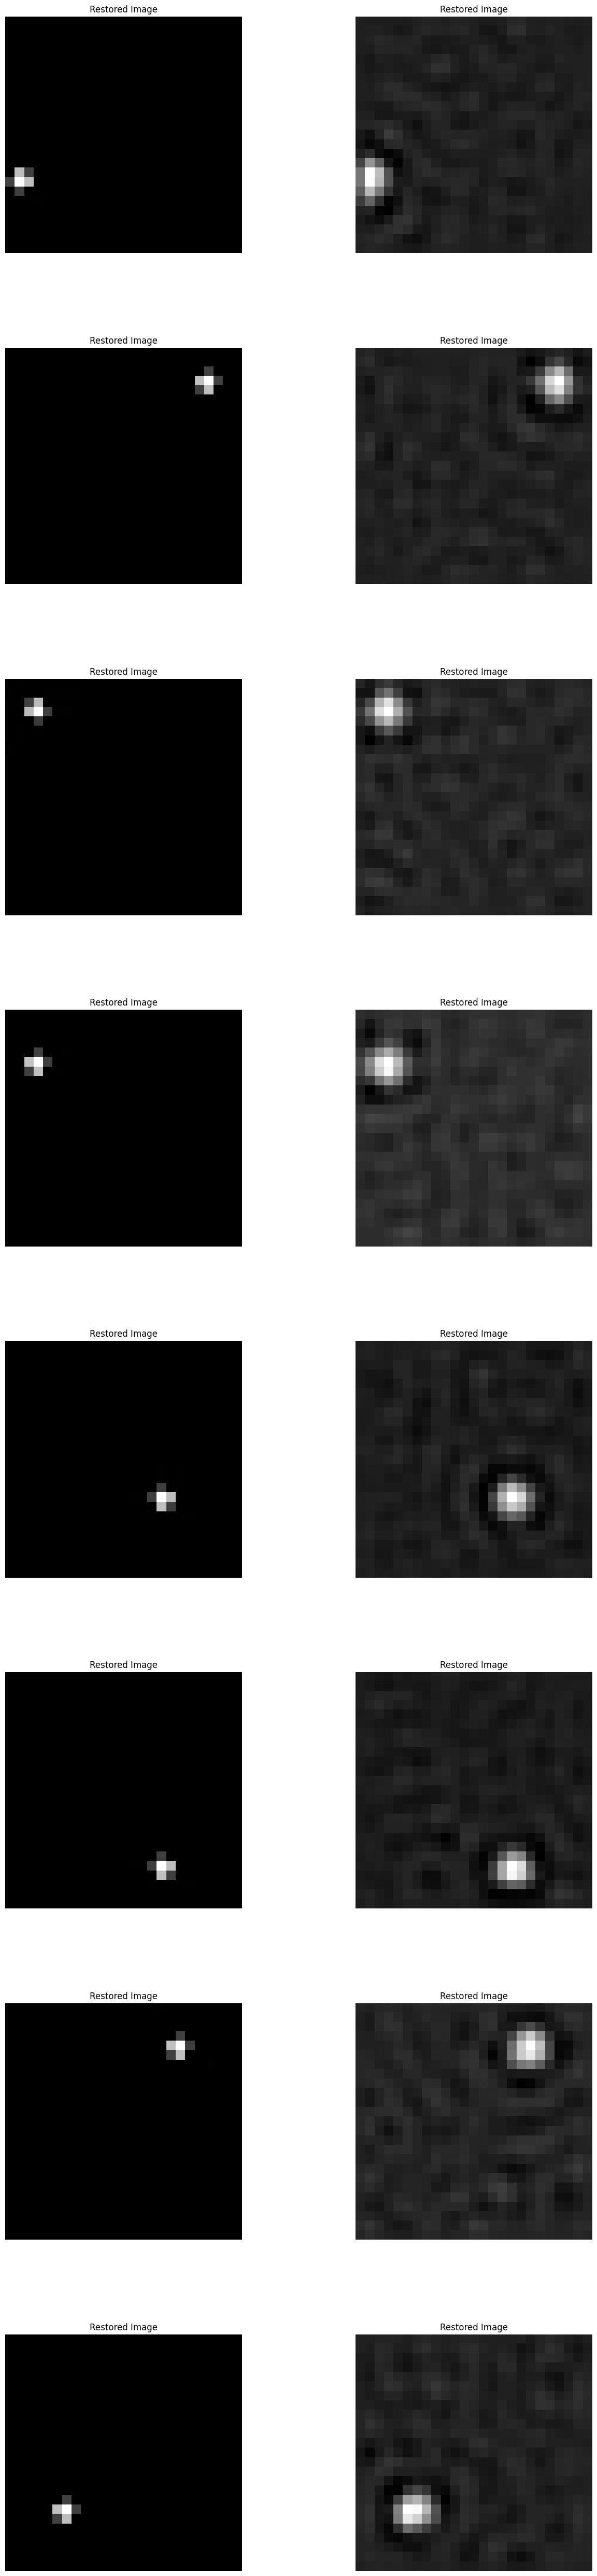

In [41]:
plt.figure(figsize=(16, 64))
for i in range(8):
    original_frame = flattened_trainImgs[i].reshape(25, 25)
    Output_frame = Output[i].detach().reshape(25,25)
    plt.subplot(8, 2, (i + 1) * 2 - 1)
    plt.imshow(original_frame, cmap='gray')  # 使用灰度颜色映射
    plt.title('Restored Image')
    plt.axis('off')  # 不显示坐标轴
    plt.subplot(8, 2, (i + 1) * 2)
    plt.imshow(Output_frame, cmap='gray')  # 使用灰度颜色映射
    plt.title('Restored Image')
    plt.axis('off')  # 不显示坐标轴
plt.subplots_adjust(wspace=0.2, hspace=0.4)  # wspace是子图之间的宽度间距，hspace是高度间距
plt.show()

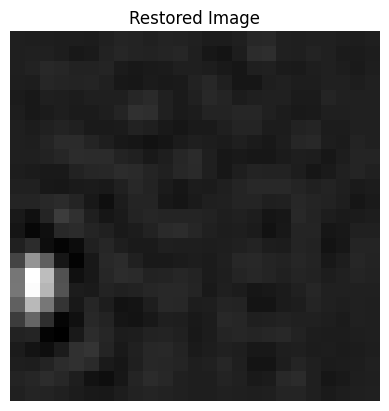

In [24]:
Output_frame = Output[0].reshape(25,25)

plt.imshow(original_frame, cmap='gray')  # 使用灰度颜色映射
plt.title('Restored Image')
plt.axis('off')  # 不显示坐标轴
plt.show()